## Pre-requisite

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd "/content/drive/MyDrive/Zero/Zero"

/content/drive/MyDrive/Zero/Zero


In [ ]:
pip install adjustText kneed bertopic

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Code

In [ ]:
import os
import json
import re
import textwrap
import pickle
import scipy
import ast
import math

import statsmodels as sm
import statsmodels.api as sm
import statsmodels as sm

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.cm import get_cmap
cmap_autumn = get_cmap('autumn')
cmap_winter = get_cmap('winter')

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from adjustText import adjust_text

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
p_stemmer = PorterStemmer()

from kneed import KneeLocator

from bertopic import BERTopic

import gensim
from gensim import corpora, models
from gensim.models import word2vec, Word2Vec
import gensim.corpora as corpora

from transformers import pipeline
multilingual_classifier = pipeline('sentiment-analysis', model='nlptown/bert-base-multilingual-uncased-sentiment')

from datetime import datetime, timedelta
from itertools import islice
from collections import Counter, defaultdict

from wordcloud import WordCloud, STOPWORDS

from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
from sklearn.neighbors import KernelDensity

from tqdm import tqdm

start = datetime.strptime("01-01-2018", "%d-%m-%Y")
end = datetime.strptime("31-12-2022", "%d-%m-%Y")
dates = [start + timedelta(days=x) for x in range(0, (end-start).days)]
x = np.linspace(1, len(dates), len(dates))

weight_for_gt = {
    "climate_engineering": 795000000,
    "geoengineering": 7530000,
    "solar_geoengineering": 1890000,
    "carbon_capture_and_removal": 55900000,
    "stratospheric_aerosol_injection": 289000,
    "cloud_brightening": 7000000,
    "ocean_fertilization": 8410000,
    "biochar": 24300000,
    "afforestation": 15000000,
    "reforestation": 30600000,
    "ecosystem_restoration": 139000000,
}

scaler = MinMaxScaler()

stopwords = set(STOPWORDS) | set(stopwords.words('english'))

stopwords_all = stopwords | set(["will", "may", "say", "says", "said", "told", "bbc", "video", "javascript", "sites",
                                 "mr", "year", "years", "people", "new", "number", "one", "two", "first", "last", "many", "much",
                                 "need", "want", "made", "make", "take", "time", "day", "part", "work", "play", "played",
                                 "u", "n't", "content", "enable", "browser",
                                 "us", "eu", "uk", "country", "ms.", "mr.", "even", "use", "go",
                                 "de", "la", "que", "en", "lo", "el", "includ", "include", "call",
                                 "http", "https", "link"])

stopwords_all_stem = set([p_stemmer.stem(token) for token in stopwords_all])

geoengineering_terms_category_dict = {}
geoengineering_terms_category = []
with open("geoengineering_terms_category.txt") as file:
    for line in file.readlines():
        thisone = " ".join([p_stemmer.stem(i) for i in line.strip().lower().split()])
        geoengineering_terms_category_dict[thisone] = line.strip().lower()
        geoengineering_terms_category.append(thisone)
geoengineering_terms_category_process = ["_".join(i.split()) for i in geoengineering_terms_category] + ["geoengin"]

geoengineering_terms_influencer_dict = {}
geoengineering_terms_influencer = []
with open("geoengineering_terms_influencer.txt") as file:
    for line in file.readlines():
        thisone = " ".join([p_stemmer.stem(i) for i in line.strip().lower().split()])
        geoengineering_terms_influencer_dict[thisone] = line.strip().lower()
        geoengineering_terms_influencer.append(thisone)
geoengineering_terms_influencer_process = ["_".join(i.split()) for i in geoengineering_terms_influencer]

geoengineering_terms_influencer_dict_whole = geoengineering_terms_influencer_dict.copy()
for key, value in geoengineering_terms_influencer_dict.items():
    geoengineering_terms_influencer_dict_whole["_".join(value.split())] = value.title()
    geoengineering_terms_influencer_dict_whole["_".join(key.split())] = value.title()
    geoengineering_terms_influencer_dict_whole[key] = value.title()

def normalize_data(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

def plot_estimate_confidence(mean_conf, ax):
    categories = mean_conf.columns
    estimates = mean_conf.iloc[0]
    conf_intervals = list(mean_conf.iloc[1:, :].T.itertuples(index=False, name=None))

    for i, (estimate, interval) in enumerate(zip(estimates, conf_intervals)):
        ax.plot([interval[0], interval[1]], [i, i], color='skyblue')
        ax.plot(estimate, i, 'o', color='blue')
    ax.set_yticks(np.arange(len(categories)), categories)

def co_occurrence(sentences, window_size):
    d = defaultdict(int)
    vocab = set()

    for text in tqdm(sentences):
        for i in range(len(text)):
            token = text[i]
            vocab.add(token)
            next_token = text[i+1:i+1+window_size]
            for t in next_token:
                key = tuple(sorted([t, token]))
                d[key] += 1

    vocab = sorted(vocab)
    df = pd.DataFrame(data=np.zeros((len(vocab), len(vocab)), dtype=np.int16),
                      index=vocab,
                      columns=vocab)

    for key, value in tqdm(d.items()):
        df.at[key[0], key[1]] = value
        df.at[key[1], key[0]] = value
    return df

def tsne_plot(model, ax=None, random_state=1):
    labels, tokens = [], []

    for word in model.wv.index_to_key:
        tokens.append(model.wv[word])
        labels.append(word)

    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=random_state)
    new_values = tsne_model.fit_transform(np.array(tokens))

    x, y = [], []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])

    if not ax:
        fig, ax = plt.subplots(figsize=(12, 8))

    for i in tqdm(range(len(x))):
        if labels[i] in geoengineering_terms_category_process:
            ax.annotate(" ".join(labels[i].split("_")), xy=(x[i], y[i]), xytext=(5, 2),
                        textcoords='offset points', ha='right', va='bottom')
            ax.scatter(x[i], y[i], s=1)
        elif labels[i] in geoengineering_terms_influencer_process:
            ax.annotate(" ".join(labels[i].split("_")), xy=(x[i], y[i]), xytext=(5, 2),
                        textcoords='offset points', ha='right', va='bottom', color="red")
            ax.scatter(x[i], y[i], s=1)
        # else:
        #     ax.scatter(x[i], y[i], s=0.05)

def pickup_data(root):
    if root == "bbc":
        title_split = " - BBC "
    elif root == "nytimes":
        title_split = " - The New York Times"
    titles = []
    contents = []
    texts = []
    texts_multi = []
    list_root = [i for i in os.listdir(root) if i [0] != "."]
    years = sorted(list_root, key=int)
    for year in years:
        months = sorted(os.listdir(os.path.join(root, year)), key=int)
        for month in months:
            days = sorted(os.listdir(os.path.join(root, year, month)), key=int)
            for day in days:
                date = os.path.join(year, month, day)
                with open(os.path.join(root, year, month, day, 'articles')) as txt:
                    articles = json.loads(txt.read())
                    for article in articles["articles"]:
                        title = article["title"].split(title_split)[0]
                        content = article["content"]
                        description = article["description"]
                        if description is None:
                            description_input = " "
                        else:
                            description_input = " " + description + " "

                        titles += [[date, title]]
                        contents += [[date, content]]
                        texts += [[date, title + description_input + content]]
                        texts_multi += [[date, title, description, content]]
    return titles, contents, texts, texts_multi

def lower_df_data(df, index=[1,2,3]):
    if type(index) == int:
        index = [index]
    for i in index:
        df[i] = df[i].str.lower()
    return df

def choose_df_data(df, index=[1,2,3], words_need=""):
    if type(index) == int:
        index = [index]
    df_contains_temp = False
    for i in index:
        df_contains_temp = df_contains_temp | df[i].str.contains(words_need)
    df = df[df_contains_temp]
    return df

def stack_df_data(df, index=[1,2,3]):
    if type(index) == int:
        index = [index]
    df_stack = []
    for _, row in df.iterrows():
        for i in index:
            df_stack.append([row[0], row[i]])
    df_stack = pd.DataFrame(df_stack)
    return df_stack

def word_process(text):
    if text is None:
        return [""]
    text_token = nltk.word_tokenize(text)
    text_token_nonstop = [token for token in text_token if (token[0].isalpha()) and (token not in stopwords_all)]
    text_token_nonstop_stem = [p_stemmer.stem(token) for token in text_token_nonstop]
    text_token_nonstop_stem_combine = " ".join(text_token_nonstop_stem)
    for category in geoengineering_terms_category:
        if category in text_token_nonstop_stem_combine:
            text_token_nonstop_stem_combine = text_token_nonstop_stem_combine.replace(category, "_".join(category.split()))
    for category in geoengineering_terms_influencer:
        if category in text_token_nonstop_stem_combine:
            text_token_nonstop_stem_combine = text_token_nonstop_stem_combine.replace(category, "_".join(category.split()))
    return text_token_nonstop_stem_combine.split()

def process_df_data(df, index=[1,2,3]):
    if type(index) == int:
        index = [index]
    for i in index:
        df[i] = df[i].apply(lambda x: word_process(x))
    return df

def pre_workflow(news, words_need, process=True):
    _, _, _, data = pickup_data(news)
    data = pd.DataFrame(data)
    data[0]= pd.to_datetime(data[0]).dt.strftime('%Y/%m/%d')
    data = lower_df_data(data)
    data = choose_df_data(data, words_need=words_need)
    data = stack_df_data(data)
    if process:
        data = process_df_data(data, index=1)
    return data

def time_range_split(start, end, num):
    if num == 5:
        return ["2018/01/01", "2018/12/31",
                "2019/01/01", "2019/12/31",
                "2020/01/01", "2020/12/31",
                "2021/01/01", "2021/12/31",
                "2022/01/01", "2022/12/31"]
    fmt = "%Y/%m/%d"
    start = datetime.strptime(start, fmt)
    end = datetime.strptime(end, fmt)
    diff = (end - start) / num
    split_points = []
    for i in range(num):
        split_points.append((start + diff * i).strftime(fmt))
        if i > 0:
            split_points.append((start + diff * i + timedelta(days = 1)).strftime(fmt))
    split_points.append(end.strftime(fmt))
    return split_points

def split_df_data(data, num, time_col_number = 0):
    split_points = time_range_split(data.iloc[0, time_col_number], data.iloc[-1, time_col_number], num)
    data_split = []
    for i in range(len(split_points) // 2):
        data_split.append(data[(data.iloc[:, time_col_number] >= split_points[i*2]) & (data.iloc[:, time_col_number] <= split_points[i*2+1])])
    return data_split, split_points

def draw_wordcloud(words, stopwords = stopwords, ax=None, width = 800, height = 400):
    wordcloud = WordCloud(width = width, height = height,
                    background_color ='white',
                    stopwords = stopwords,
                    collocation_threshold = 1000,
                    min_font_size = 5).generate(words)

    if ax is None:
        _, ax = plt.subplots(figsize = (8, 8), facecolor = None)
        ax.imshow(wordcloud)
    else:
        ax.imshow(wordcloud)

    ax.axis("off");

def draw_wordcloud_df_data(data, ax=None, width = 800, height = 400, text_col=1):
    words = " ".join(data[text_col].apply(lambda x: " ".join(x)))
    draw_wordcloud(words, stopwords = stopwords_all_stem, ax=ax, width = width, height = height)

def draw_wordcloud_list_data(data_splits, data_split_points, title="", text_col=1):
    fig, axes = plt.subplots(nrows=1, ncols=len(data_splits), figsize=(30,10))
    for i, data_split in enumerate(data_splits):
        draw_wordcloud_df_data(data_split, ax = axes[i], width = 800, height = 1600, text_col=text_col)
        axes[i].set_title("%s ~ %s" % (data_split_points[i*2], data_split_points[i*2+1]))
    fig.suptitle(title)
    fig.tight_layout();

def draw_termfreq_df_data(data, num_terms, ax=None, text_col=1):
    words = list([a for b in data[text_col].tolist() for a in b])
    words_termfreq = Counter(words).most_common(num_terms)
    words_termfreq = pd.DataFrame(words_termfreq).set_index(0)[::-1]
    words_termfreq.plot.barh(ax=ax)

def draw_termfreq_list_data(data_splits, data_split_points, num_terms, title="", text_col=1):
    fig, axes = plt.subplots(nrows=1, ncols=len(data_splits), figsize=(20,8))
    for i, data_split in enumerate(data_splits):
        draw_termfreq_df_data(data_split, num_terms, ax=axes[i], text_col=text_col)
        axes[i].legend().set_visible(False)
        axes[i].set_title("%s ~ %s" % (data_split_points[i*2], data_split_points[i*2+1]))
        axes[i].set_ylabel("")
    fig.suptitle(title)
    fig.tight_layout();

def draw_lda_df_data(data, num_topics, num_words, show_formatted=False):
    dictionary = corpora.Dictionary(data[1])
    corpus = [dictionary.doc2bow(i) for i in data[1]]
    ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=5, id2word = dictionary, random_state=706)
    if show_formatted:
        print(ldamodel.print_topics(num_topics=num_topics, num_words=num_words))
    lda_results = ldamodel.show_topics(num_topics=num_topics, num_words=num_words, formatted=False)
    return lda_results

def draw_lda_list_data(data_splits, data_split_points, num_topics, num_words, title=""):
    print(title, end="\n\n")
    for i, data_split in enumerate(data_splits):
        print("%s ~ %s" % (data_split_points[i*2], data_split_points[i*2+1]))
        lda_results = draw_lda_df_data(data_split, num_topics, num_words)
        for topic in lda_results:
            print()
            for token in topic[1]:
                print(token[0], token[1])
        print("\n\n\n")

<ipython-input-89-4b2773c9b587>:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_autumn = get_cmap('autumn')
<ipython-input-89-4b2773c9b587>:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_winter = get_cmap('winter')


In [ ]:
with open('geoengineering_terms_influencer.txt') as file:
    geoengineering_terms = [i.strip().lower() for i in file.readlines()]
words_need = "|".join(geoengineering_terms)
words_need

'biodiversity|deforestation|natural disaster|sea level rise|plastic pollution|ocean acidification|air pollution|global warming|overfishing|climate change'

In [ ]:
# bbc_unprocess = pre_workflow("bbc", words_need, process=False)
# bbc_unprocess.to_csv("PPT/bbc_unprocess.csv", index=False)

# nytimes_unprocess = pre_workflow("nytimes", words_need, process=False)
# nytimes_unprocess.to_csv("PPT/nytimes_unprocess.csv", index=False)

In [ ]:
bbc_unprocess = pd.read_csv('PPT/bbc_unprocess.csv', names=[0,1], header=0)
bbc_unprocess[1] = bbc_unprocess[1].fillna("")
nytimes_unprocess = pd.read_csv('PPT/nytimes_unprocess.csv', names=[0,1], header=0)
nytimes_unprocess[1] = nytimes_unprocess[1].fillna("")

In [ ]:
bbc_unprocess = pd.read_csv('bbc_unprocess.csv', names=[0,1], header=0)
bbc_unprocess[1] = bbc_unprocess[1].fillna("")
nytimes_unprocess = pd.read_csv('nytimes_unprocess.csv', names=[0,1], header=0)
nytimes_unprocess[1] = nytimes_unprocess[1].fillna("")

bbc_unprocess_agg = bbc_unprocess.groupby(bbc_unprocess.index // 3)[1].agg(lambda x: x.iloc[0]+ " \n " + x.iloc[1] + " \n " + x.iloc[2]).to_frame()
bbc_unprocess_agg_time = bbc_unprocess.groupby(bbc_unprocess.index // 3)[0].agg(lambda x: x.iloc[0]).to_frame()
bbc_unprocess_agg_df = pd.concat([bbc_unprocess_agg_time, bbc_unprocess_agg], axis=1)
bbc_unprocess_agg_df[2] = "BBC"

nytimes_unprocess_agg = nytimes_unprocess.groupby(nytimes_unprocess.index // 3)[1].agg(lambda x: x.iloc[0]+ " \n " + x.iloc[1] + " \n " + x.iloc[2]).to_frame()
nytimes_unprocess_agg_time = nytimes_unprocess.groupby(nytimes_unprocess.index // 3)[0].agg(lambda x: x.iloc[0]).to_frame()
nytimes_unprocess_agg_df = pd.concat([nytimes_unprocess_agg_time, nytimes_unprocess_agg], axis=1)
nytimes_unprocess_agg_df[2] = "NYTimes"

data_unprocess_agg_df_both1 = pd.concat([bbc_unprocess_agg_df, nytimes_unprocess_agg_df]).sort_values(0)
data_unprocess_agg_df_both1[3] = 0

bbc_unprocess = pd.read_csv('PPT/bbc_unprocess.csv', names=[0,1], header=0)
bbc_unprocess[1] = bbc_unprocess[1].fillna("")
nytimes_unprocess = pd.read_csv('PPT/nytimes_unprocess.csv', names=[0,1], header=0)
nytimes_unprocess[1] = nytimes_unprocess[1].fillna("")

bbc_unprocess_agg = bbc_unprocess.groupby(bbc_unprocess.index // 3)[1].agg(lambda x: x.iloc[0]+ " \n " + x.iloc[1] + " \n " + x.iloc[2]).to_frame()
bbc_unprocess_agg_time = bbc_unprocess.groupby(bbc_unprocess.index // 3)[0].agg(lambda x: x.iloc[0]).to_frame()
bbc_unprocess_agg_df = pd.concat([bbc_unprocess_agg_time, bbc_unprocess_agg], axis=1)
bbc_unprocess_agg_df[2] = "BBC"

nytimes_unprocess_agg = nytimes_unprocess.groupby(nytimes_unprocess.index // 3)[1].agg(lambda x: x.iloc[0]+ " \n " + x.iloc[1] + " \n " + x.iloc[2]).to_frame()
nytimes_unprocess_agg_time = nytimes_unprocess.groupby(nytimes_unprocess.index // 3)[0].agg(lambda x: x.iloc[0]).to_frame()
nytimes_unprocess_agg_df = pd.concat([nytimes_unprocess_agg_time, nytimes_unprocess_agg], axis=1)
nytimes_unprocess_agg_df[2] = "NYTimes"

data_unprocess_agg_df_both2 = pd.concat([bbc_unprocess_agg_df, nytimes_unprocess_agg_df]).sort_values(0)
data_unprocess_agg_df_both2[3] = 0

In [ ]:
len(data_unprocess_agg_df_both1) + len(data_unprocess_agg_df_both2)

36868

In [ ]:
data_unprocess_agg_df_both2.loc[(data_unprocess_agg_df_both2[0] == date) & (data_unprocess_agg_df_both2[2] == source), 1]

0    fighting climate change, one laundry load at a...
2    the hunt for ‘fire cats’ amid northern califor...
3    with disney deal looming, murdoch’s empire is ...
4    2 american families are mourned after plane cr...
5    the trump effect: business, anticipating less ...
6    calestous juma, 64, dies; sought innovation in...
7    a prescient sci-fi ‘parable’ gets set to music...
1    weather and visiting senator steal the show at...
Name: 1, dtype: object

In [ ]:
data_unprocess_agg_df_both2

,0,1,2,3
0,2018/01/01,"fighting climate change, one laundry load at a...",NYTimes,0
2,2018/01/01,the hunt for ‘fire cats’ amid northern califor...,NYTimes,0
3,2018/01/01,"with disney deal looming, murdoch’s empire is ...",NYTimes,0
4,2018/01/01,2 american families are mourned after plane cr...,NYTimes,0
5,2018/01/01,"the trump effect: business, anticipating less ...",NYTimes,0
...,...,...,...,...
2994,2022/12/31,new year honours 2023: brian may and lionesses...,BBC,0
13032,2022/12/31,opinion | biden set an ambitious goal for natu...,NYTimes,0
2993,2022/12/31,happisburgh: the norfolk village crumbling int...,BBC,0
2995,2022/12/31,the uk's problems will not all go away in 2023...,BBC,0


In [ ]:
year_count = {"2018": {"BBC": 0, "NYTimes": 0},
              "2019": {"BBC": 0, "NYTimes": 0},
              "2020": {"BBC": 0, "NYTimes": 0},
              "2021": {"BBC": 0, "NYTimes": 0},
              "2022": {"BBC": 0, "NYTimes": 0}}
total_n = len(data_unprocess_agg_df_both1) + len(data_unprocess_agg_df_both2)
for index, row in data_unprocess_agg_df_both1.iterrows():
  date, text, source = row[0], row[1], row[2]
  year_count[date.split("/")[0]][source] += 1
  boolean_series = data_unprocess_agg_df_both2.loc[(data_unprocess_agg_df_both2[0] == date) & (data_unprocess_agg_df_both2[2] == source), 1] == text
  if any(boolean_series):
    if sum(boolean_series) > 1:
      print(row)
      print(sum(boolean_series))
    total_n -= 1

print()
for index, row in data_unprocess_agg_df_both2.iterrows():
  date, text, source = row[0], row[1], row[2]
  year_count[date.split("/")[0]][source] += 1
  boolean_series = data_unprocess_agg_df_both1.loc[(data_unprocess_agg_df_both1[0] == date) & (data_unprocess_agg_df_both1[2] == source), 1] == text
  if any(boolean_series):
    if sum(boolean_series) > 1:
      print(row)
      print(sum(boolean_series))
    year_count[date.split("/")[0]][source] -= 1

0                                           2018/08/13
1    jakarta, the fastest-sinking city in the world...
2                                                  BBC
3                                                    0
Name: 313, dtype: object
2
0                                           2018/08/13
1    jakarta, the fastest-sinking city in the world...
2                                                  BBC
3                                                    0
Name: 314, dtype: object
2
0                                           2019/11/26
1    holiday books \n the latest books to give — an...
2                                              NYTimes
3                                                    0
Name: 6437, dtype: object
2
0                                           2019/11/26
1    holiday books \n the latest books to give — an...
2                                              NYTimes
3                                                    0
Name: 6422, dtype: object
2

0        

In [ ]:
year_count

{'2018': {'BBC': 664, 'NYTimes': 4508},
 '2019': {'BBC': 1013, 'NYTimes': 5380},
 '2020': {'BBC': 893, 'NYTimes': 4888},
 '2021': {'BBC': 1402, 'NYTimes': 5604},
 '2022': {'BBC': 1361, 'NYTimes': 5060}}

In [ ]:
np.median([664, 1013, 893, 1402, 1361])

1013.0

In [ ]:
np.sum([4508, 5380, 4888, 5604, 5060])

25440

In [ ]:
25440 + 5333

30773

In [ ]:
year_count

{'2018': 5172, '2019': 6393, '2020': 5781, '2021': 7006, '2022': 6421}

In [ ]:
total_n

30773

### Sentiment Time Series*

In [ ]:
bbc_unprocess_agg = bbc_unprocess.groupby(bbc_unprocess.index // 3)[1].agg(lambda x: x.iloc[0]+ " \n " + x.iloc[1] + " \n " + x.iloc[2]).to_frame()
bbc_unprocess_agg_time = bbc_unprocess.groupby(bbc_unprocess.index // 3)[0].agg(lambda x: x.iloc[0]).to_frame()
bbc_unprocess_agg_df = pd.concat([bbc_unprocess_agg_time, bbc_unprocess_agg], axis=1)
bbc_unprocess_agg_df[2] = "BBC"

nytimes_unprocess_agg = nytimes_unprocess.groupby(nytimes_unprocess.index // 3)[1].agg(lambda x: x.iloc[0]+ " \n " + x.iloc[1] + " \n " + x.iloc[2]).to_frame()
nytimes_unprocess_agg_time = nytimes_unprocess.groupby(nytimes_unprocess.index // 3)[0].agg(lambda x: x.iloc[0]).to_frame()
nytimes_unprocess_agg_df = pd.concat([nytimes_unprocess_agg_time, nytimes_unprocess_agg], axis=1)
nytimes_unprocess_agg_df[2] = "NYTimes"

data_unprocess_agg_df = pd.concat([bbc_unprocess_agg_df, nytimes_unprocess_agg_df]).sort_values(0)
data_unprocess_agg_df[3] = 0

In [ ]:
# for index, (i, line) in tqdm(enumerate(data_unprocess_agg_df.iterrows()), total=data_unprocess_agg_df.shape[0]):
#   try:
#     result = multilingual_classifier(line[1])
#     scores_mean = int(result[0]["label"].split()[0]) - 1 + result[0]["score"]
#   except RuntimeError:
#     scores = []
#     items = textwrap.wrap(line[1], 1000)
#     for item in items:
#         result = multilingual_classifier(item)
#         scores.append(int(result[0]["label"].split()[0]) - 1 + result[0]["score"])
#     scores_mean = np.mean(scores)
#   data_unprocess_agg_df.iloc[index, 3] = scores_mean
#   with open("PPT/sentiment_scores.txt", "a") as file:
#     file.write(str(index) + " " + str(scores_mean) + "\n")

  0%|          | 12/16030 [00:24<9:01:10,  2.03s/it]


KeyboardInterrupt: 

In [ ]:
# data_unprocess_agg_df.to_csv('PPT/data_unprocess_agg_df_sentiment.csv', index=False)

In [ ]:
bbc_unprocess_agg_df = pd.read_csv('PPT/data_unprocess_agg_df_sentiment.csv')

In [ ]:
bbc_unprocess_agg_df_sorted = bbc_unprocess_agg_df.sort_values("3")
for i in range(-800, -750):
  print(bbc_unprocess_agg_df_sorted.iloc[i]["1"], bbc_unprocess_agg_df_sorted.iloc[i]["3"])

being there: our favorite dispatches from every corner of the world 
 we reported this year from over 100 countries, and in a new feature, the dispatch, we invited you to come along for a bumpy, exhilarating, emotionally wrenching ride. 
 sergey ponomarev for the new york times

sergey ponomarev for the new york times

credit... sergey ponomarev for the new york times

aida akmatova developed her signature trick of shooting a bow and arrow with her feet as a circus performer. she called the world nomad games “a key event in my life.”

being there: our favorite dispatches from every corner of the world

his pacific island was swallowed by rising seas. so he moved to a new one. three islands in the south pacific are being swept away by currents and climate change. but the seaweed farmers there are doing everything they can to stay. from a seaweed farmer forced to adapt to some african elephants that have evolved a strategy to help them defeat poachers: 3.4091004133224487
cop 26: the teen

,0,3
0,2018/01/01,2.915895
1,2018/01/01,2.416906
2,2018/01/01,1.571567
3,2018/01/01,2.190285
4,2018/01/01,1.684777
...,...,...
16025,2022/12/31,3.431733
16026,2022/12/31,3.097252
16027,2022/12/31,2.743065
16028,2022/12/31,2.113198


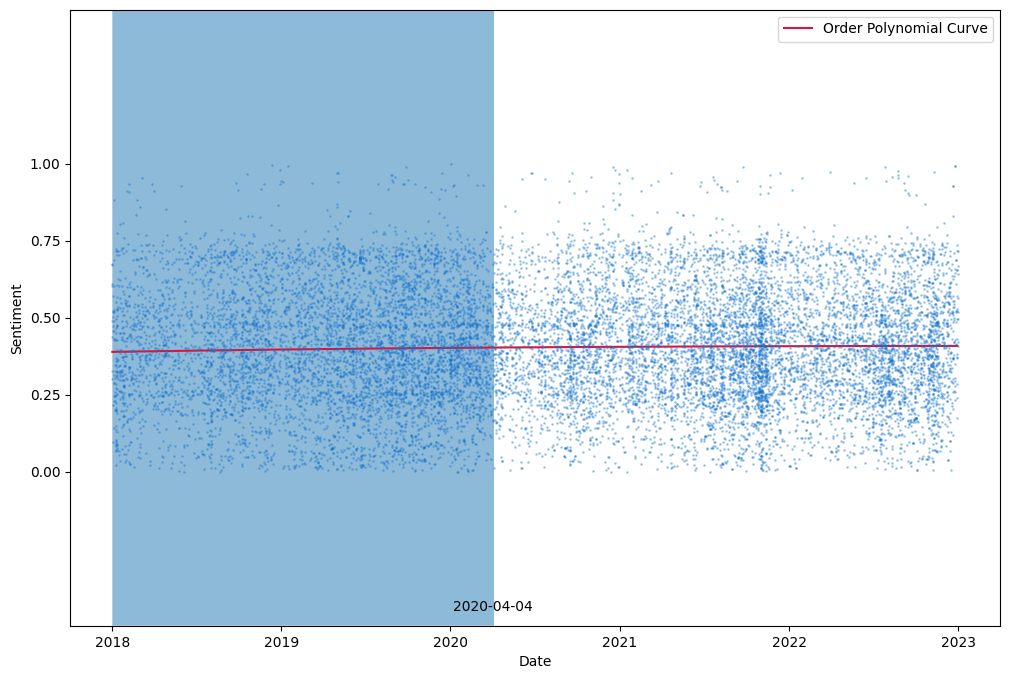

In [ ]:
bbc_unprocess_agg_df_scatter = bbc_unprocess_agg_df.rename({"0": 0, "3": 3}, axis=1).iloc[:, [0,3]].rename({0: "date", 3: "sentiment"}, axis=1)
bbc_unprocess_agg_df_scatter["date"] = pd.to_datetime(bbc_unprocess_agg_df_scatter["date"])
bbc_unprocess_agg_df_scatter = bbc_unprocess_agg_df_scatter.set_index("date")
bbc_unprocess_agg_df_scatter["sentiment"] = normalize_data(bbc_unprocess_agg_df_scatter["sentiment"])

orderth = 5
model_poly = np.poly1d(np.polyfit(np.linspace(1, len(bbc_unprocess_agg_df_scatter), len(bbc_unprocess_agg_df_scatter)), bbc_unprocess_agg_df_scatter.sentiment, orderth))
bbc_y = model_poly(x)
bbc_kn = KneeLocator(x, bbc_y, curve='concave', direction='increasing').knee

fig, ax = plt.subplots(figsize=(12,8))
ax.fill_between([dates[int(i)-1] for i in x], -0.5, 1.5, where = x <= bbc_kn, alpha=0.5)
ax.plot(dates, bbc_y, color="#DC143C", label="Order Polynomial Curve")
ax.plot_date(bbc_unprocess_agg_df_scatter.index, bbc_unprocess_agg_df_scatter["sentiment"], xdate=True, ydate=False, markersize=1, alpha=0.3, color="#1874CD")
ax.text(dates[int(bbc_kn)-90], -0.45, dates[int(bbc_kn)-1].strftime("%Y-%m-%d"))
ax.set_ylim([-0.5,1.5])
ax.legend()
ax.set_xlabel("Date")
ax.set_ylabel("Sentiment")
ax.set_yticklabels(["", "", "0.00", "0.25", "0.50", "0.75", "1.00", "", ""])
for i in [0, 1,-2,-1]:
    ax.yaxis.get_major_ticks()[i].draw = lambda *args:None

In [ ]:
# for index, line in tqdm(nytimes_unprocess_agg_df.iterrows(), total=len(nytimes_unprocess_agg_df)):
#     # if index < 11824:
#     #     continue
#     scores = []
#     for item in line[2]:
#         try:
#             result = multilingual_classifier(item)
#             scores.append(int(result[0]["label"].split()[0]) - 1 + result[0]["score"])
#         except RuntimeError:
#             items = textwrap.wrap(item, len(item)//1.9)
#             for item in items:
#                 result = multilingual_classifier(item)
#                 scores.append(int(result[0]["label"].split()[0]) - 1 + result[0]["score"])
#     nytimes_unprocess_agg_df.iloc[index, 3] = np.mean(scores)

In [ ]:
# nytimes_unprocess_agg_df.to_csv('PPT/nytimes_unprocess_agg_df.csv', index=False)

In [ ]:
nytimes_unprocess_agg_df = pd.read_csv('PPT/nytimes_unprocess_agg_df.csv', index_col=0, names=[0,1,2,3,4,5], header=0)

ParserError: Too many columns specified: expected 6 and found 3

In [1]:
nytimes_unprocess_agg_df_scatter = nytimes_unprocess_agg_df.iloc[:, [0,3]].rename({0: "date", 3: "sentiment"}, axis=1)
nytimes_unprocess_agg_df_scatter["date"] = pd.to_datetime(nytimes_unprocess_agg_df_scatter["date"])
nytimes_unprocess_agg_df_scatter = nytimes_unprocess_agg_df_scatter.set_index("date")
nytimes_unprocess_agg_df_scatter["sentiment"] = normalize_data(nytimes_unprocess_agg_df_scatter["sentiment"])

orderth = 5
model_poly = np.poly1d(np.polyfit(np.linspace(1, len(nytimes_unprocess_agg_df_scatter), len(nytimes_unprocess_agg_df_scatter)), nytimes_unprocess_agg_df_scatter.sentiment, orderth))
nytimes_y = model_poly(x)
nytimes_kn = KneeLocator(x, nytimes_y, curve='concave', direction='increasing').knee

fig, ax = plt.subplots(figsize=(12,8))
# ax.fill_between([dates[int(i)-1] for i in x], -0.5, 1.5, where = x <= nytimes_kn, alpha=0.5)
ax.plot(dates, nytimes_y, color="#DC143C", label="Order Polynomial Curve")
ax.plot_date(nytimes_unprocess_agg_df_scatter.index, nytimes_unprocess_agg_df_scatter["sentiment"], xdate=True, ydate=False, markersize=1, alpha=0.3, color="#1874CD")
ax.text(dates[int(nytimes_kn)-90], -0.45, dates[int(nytimes_kn)-1].strftime("%Y-%m-%d"))
ax.set_ylim([-0.5,1.5])
ax.legend()
ax.set_xlabel("Date")
ax.set_ylabel("Sentiment")
ax.set_yticklabels(["", "", "0.00", "0.25", "0.50", "0.75", "1.00", "", ""])
for i in [0, 1,-2,-1]:
    ax.yaxis.get_major_ticks()[i].draw = lambda *args:None

In [2]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(dates, bbc_y, color="#DC143C", label="BBC")
ax.plot(dates, nytimes_y, color="#1874CD", label="NYTimes")
ax.plot_date(bbc_unprocess_agg_df_scatter.index, bbc_unprocess_agg_df_scatter["sentiment"], xdate=True, ydate=False, markersize=1, alpha=0.2, color="#DC143C")
ax.plot_date(nytimes_unprocess_agg_df_scatter.index, nytimes_unprocess_agg_df_scatter["sentiment"], xdate=True, ydate=False, markersize=1, alpha=0.2, color="#1874CD")
ax.set_ylim([-0.5,1.5])
ax.legend(title="Polynomial Curve")
ax.set_xlabel("Date")
ax.set_ylabel("Sentiment")
ax.set_yticklabels(["", "", "0.00", "0.25", "0.50", "0.75", "1.00", "", ""])
for i in [0, 1,-2,-1]:
    ax.yaxis.get_major_ticks()[i].draw = lambda *args:None

In [ ]:
data_unprocess_agg_df_sentiment = pd.read_csv("PPT/data_unprocess_agg_df_sentiment.csv")

In [ ]:
data_unprocess_agg_df_sentiment["0"].iloc[0]

Timestamp('2018-01-01 00:00:00')

<ipython-input-84-34cca833dedc>:27: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  lgnd.legendHandles[1].set_markersize(6);


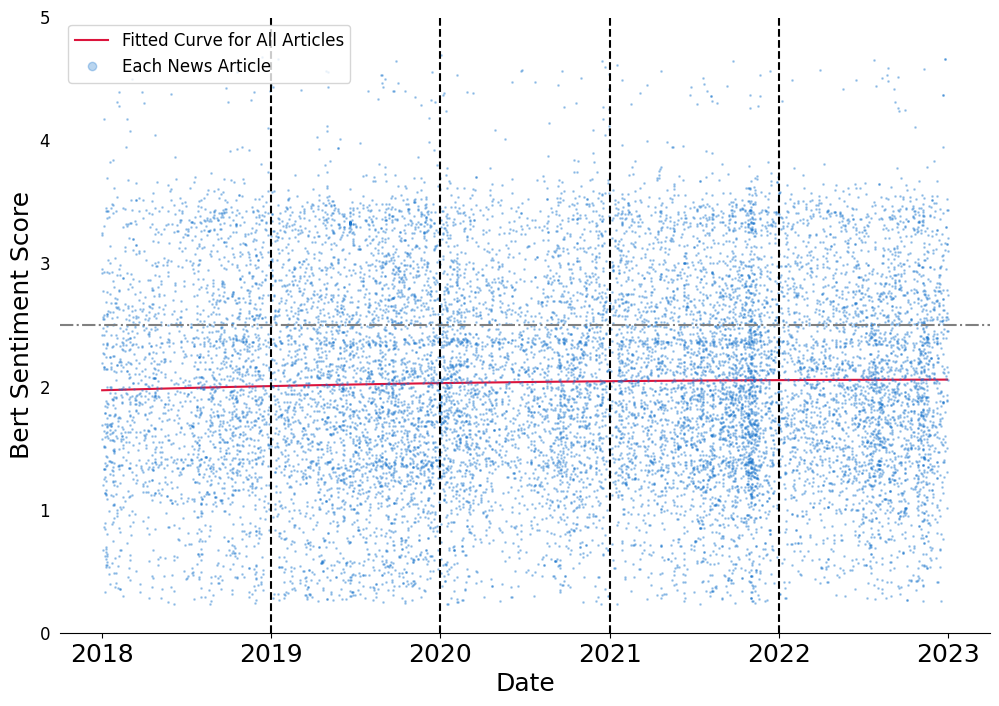

In [ ]:
model_poly = np.poly1d(np.polyfit(np.linspace(1, len(data_unprocess_agg_df_sentiment), len(data_unprocess_agg_df_sentiment)), data_unprocess_agg_df_sentiment["3"], orderth))
bbc_y = model_poly(x)

fig, ax = plt.subplots(figsize=(12,8))
ax.plot(dates, bbc_y, color="#DC143C", label="Fitted Curve for All Articles")
data_unprocess_agg_df_sentiment["0"] = pd.to_datetime(data_unprocess_agg_df_sentiment["0"])
ax.plot_date(data_unprocess_agg_df_sentiment["0"], data_unprocess_agg_df_sentiment["3"], xdate=True, ydate=False, markersize=1, alpha=0.3, color="#1874CD", label="Each News Article")
ax.set_xlabel("Date", fontsize=18)
ax.set_ylabel("Bert Sentiment Score", fontsize=18)
ax.set_ylim([0, 5])
ax.tick_params(axis='y', which='major', labelsize=12)
ax.tick_params(axis='x', which='major', labelsize=18)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
# ax.spines['bottom'].set_visible(False)
ax.tick_params(top=False, bottom=True, left=False, right=False, labelleft=True, labelbottom=True)

ax.axvline(datetime(2019,1,1), color="black", linestyle="--")
ax.axvline(datetime(2020,1,1), color="black", linestyle="--")
ax.axvline(datetime(2021,1,1), color="black", linestyle="--")
ax.axvline(datetime(2022,1,1), color="black", linestyle="--")

ax.axhline(2.5, color="grey", linestyle="dashdot")

lgnd = ax.legend(prop={'size': 12})
lgnd.legendHandles[1].set_markersize(6);

In [ ]:
lgnd.legendHandles[1]

<ipython-input-77-c8db21746bac>:1: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  lgnd.legendHandles[1]


In [ ]:
data_unprocess_agg_df_sentiment
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(dates, bbc_y, color="#DC143C", label="BBC")
ax.plot(dates, nytimes_y, color="#1874CD", label="NYTimes")
ax.plot_date(bbc_unprocess_agg_df_scatter.index, bbc_unprocess_agg_df_scatter["sentiment"], xdate=True, ydate=False, markersize=1, alpha=0.2, color="#DC143C")
ax.plot_date(nytimes_unprocess_agg_df_scatter.index, nytimes_unprocess_agg_df_scatter["sentiment"], xdate=True, ydate=False, markersize=1, alpha=0.2, color="#1874CD")
ax.set_ylim([-0.5,1.5])
ax.legend(title="Polynomial Curve")
ax.set_xlabel("Date")
ax.set_ylabel("Sentiment")
ax.set_yticklabels(["", "", "0.00", "0.25", "0.50", "0.75", "1.00", "", ""])
for i in [0, 1,-2,-1]:
    ax.yaxis.get_major_ticks()[i].draw = lambda *args:None

,0,1,2,3
0,2018/01/01,"fighting climate change, one laundry load at a...",NYTimes,2.915895
1,2018/01/01,the hunt for ‘fire cats’ amid northern califor...,NYTimes,2.416906
2,2018/01/01,"with disney deal looming, murdoch’s empire is ...",NYTimes,1.571567
3,2018/01/01,2 american families are mourned after plane cr...,NYTimes,2.190285
4,2018/01/01,"the trump effect: business, anticipating less ...",NYTimes,1.684777
...,...,...,...,...
16025,2022/12/31,new year honours 2023: brian may and lionesses...,BBC,3.431733
16026,2022/12/31,opinion | biden set an ambitious goal for natu...,NYTimes,3.097252
16027,2022/12/31,happisburgh: the norfolk village crumbling int...,BBC,2.743065
16028,2022/12/31,the uk's problems will not all go away in 2023...,BBC,2.113198


### Topic modeling

In [ ]:
# bbc_unprocess_agg_df_temp = bbc_unprocess_agg_df[[0, 1]]
# bbc_unprocess_agg_df_temp[2] = "BBC"
# nytimes_unprocess_agg_df_temp = nytimes_unprocess_agg_df[[0, 1]]
# nytimes_unprocess_agg_df_temp[2] = "NYTimes"
# data_unprocess_agg_df = pd.concat([bbc_unprocess_agg_df_temp, nytimes_unprocess_agg_df_temp], axis=0)
# data_unprocess_agg_df = data_unprocess_agg_df.sort_values(0)

# data_topic_model = BERTopic(verbose=False)
# data_topics, data_probs = data_topic_model.fit_transform(data_unprocess_agg_df[1])
# data_all_topics = data_topic_model.get_topic_info()
# data_document_topics = data_topic_model.get_document_info(data_unprocess_agg_df[1])
# data_unprocess_agg_df[4] = data_document_topics["Name"]
# data_unprocess_agg_df[5] = data_document_topics["Probability"]

In [ ]:
data_unprocess_agg_df = pd.read_csv('data_unprocess_agg_df.csv', index_col=0, names=[0, 1, 2, 4, 5], header=0)

In [ ]:
data_unprocess_agg_df_lda = data_unprocess_agg_df[[0, 4, 5]]
data_unprocess_agg_df_lda_pivot = pd.pivot_table(data_unprocess_agg_df_lda, index=0, columns=4, values=5, aggfunc='sum').fillna(0)
data_unprocess_agg_df_lda_pivot.index = pd.to_datetime(data_unprocess_agg_df_lda_pivot.index)
data_unprocess_agg_df_lda_pivot_year = data_unprocess_agg_df_lda_pivot.groupby(data_unprocess_agg_df_lda_pivot.index.year).sum()

In [ ]:
data_bbc_unprocess_agg_df = data_unprocess_agg_df[data_unprocess_agg_df[2] == "BBC"]
data_nytimes_unprocess_agg_df = data_unprocess_agg_df[data_unprocess_agg_df[2] == "NYTimes"]
data_bbc_unprocess_agg_df_lda_pivot = pd.pivot_table(data_bbc_unprocess_agg_df, index=0, columns=4, values=5, aggfunc='sum').fillna(0)
data_bbc_unprocess_agg_df_lda_pivot.index = pd.to_datetime(data_bbc_unprocess_agg_df_lda_pivot.index)
data_bbc_unprocess_agg_df_lda_pivot_year = data_bbc_unprocess_agg_df_lda_pivot.groupby(data_bbc_unprocess_agg_df_lda_pivot.index.year).sum()
data_nytimes_unprocess_agg_df_lda_pivot = pd.pivot_table(data_nytimes_unprocess_agg_df, index=0, columns=4, values=5, aggfunc='sum').fillna(0)
data_nytimes_unprocess_agg_df_lda_pivot.index = pd.to_datetime(data_nytimes_unprocess_agg_df_lda_pivot.index)
data_nytimes_unprocess_agg_df_lda_pivot_year = data_nytimes_unprocess_agg_df_lda_pivot.groupby(data_nytimes_unprocess_agg_df_lda_pivot.index.year).sum()
data_bbc_unprocess_agg_df_lda_pivot_year_normal = data_bbc_unprocess_agg_df_lda_pivot_year.T.apply(normalize_data).apply(lambda x: x / x.sum()).T
data_bbc_unprocess_agg_df_lda_pivot_year_normal = data_bbc_unprocess_agg_df_lda_pivot_year_normal.reindex(sorted(data_bbc_unprocess_agg_df_lda_pivot_year_normal.columns, key=lambda x: int(x.split("_")[0])), axis=1)
data_nytimes_unprocess_agg_df_lda_pivot_year_normal = data_nytimes_unprocess_agg_df_lda_pivot_year.T.apply(normalize_data).apply(lambda x: x / x.sum()).T
data_nytimes_unprocess_agg_df_lda_pivot_year_normal = data_nytimes_unprocess_agg_df_lda_pivot_year_normal.reindex(sorted(data_nytimes_unprocess_agg_df_lda_pivot_year_normal.columns, key=lambda x: int(x.split("_")[0])), axis=1)

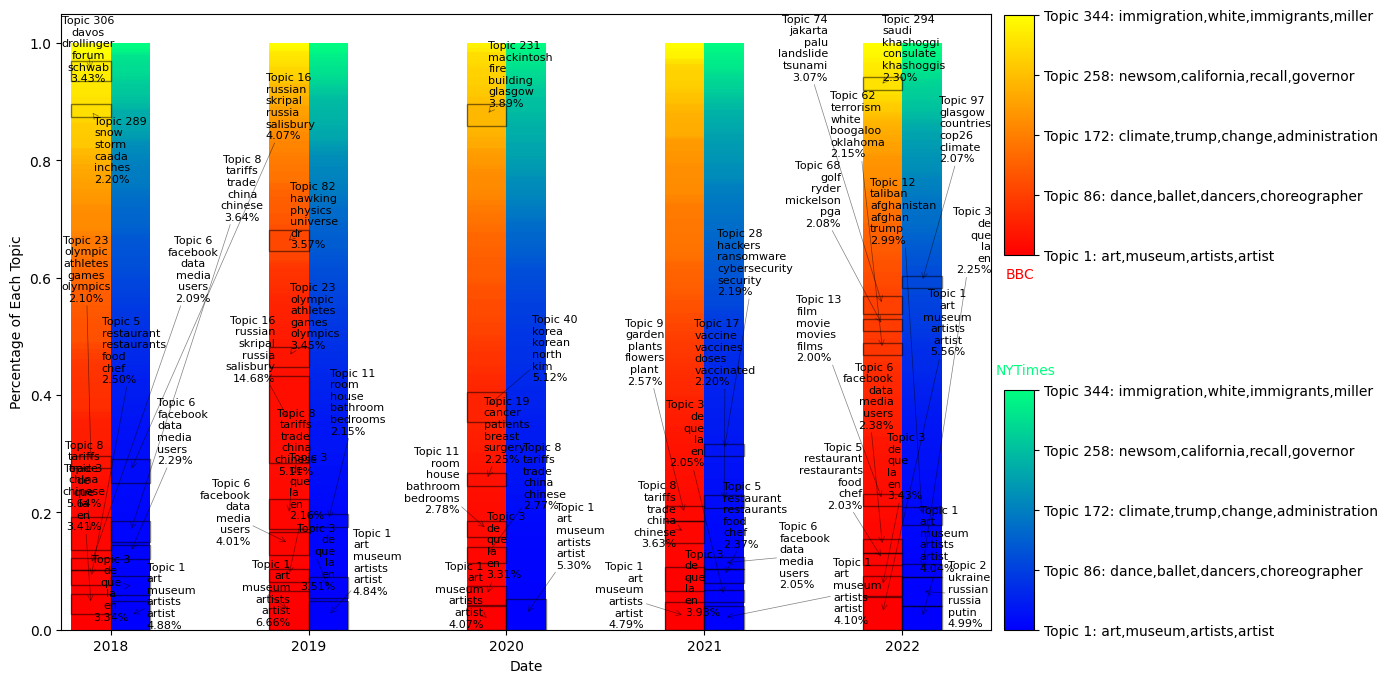

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))

colors_autumn = [cmap_autumn(decimal) for decimal in np.linspace(0.000001, 0.999999, data_bbc_unprocess_agg_df_lda_pivot_year_normal.shape[1])]
colors_winter = [cmap_winter(decimal) for decimal in np.linspace(0.000001, 0.999999, data_nytimes_unprocess_agg_df_lda_pivot_year_normal.shape[1])]

data_bbc_unprocess_agg_df_lda_pivot_year_normal.plot(kind='bar', stacked=True, position=1, ax=ax, width=0.2, color=colors_autumn)
data_nytimes_unprocess_agg_df_lda_pivot_year_normal.plot(kind='bar', stacked=True, position=0, ax=ax, width=0.2, color=colors_winter)

threshold = 0.02

ax_texts = []
for index, (year, row) in enumerate(data_bbc_unprocess_agg_df_lda_pivot_year_normal.iterrows()):
    values_before = 0
    for topic, value in row.iteritems():
        if value >= threshold:
            topics = topic.split("_")
            ax_texts.append(ax.text(index - 0.1, values_before + value / 2, "Topic %d\n" % (int(topics[0]) + 1) + "\n".join(topics[1:]) + "\n%.2f%%" % (value*100), va = 'center', ha = 'center', size=8))
            ax.add_patch(patches.Rectangle((index - 0.2, values_before), 0.2, value, linewidth=1, edgecolor='black', facecolor='none', alpha=0.5))
        values_before += value

for index, (year, row) in enumerate(data_nytimes_unprocess_agg_df_lda_pivot_year_normal.iterrows()):
    values_before = 0
    for topic, value in row.iteritems():
        if value >= threshold:
            topics = topic.split("_")
            ax_texts.append(ax.text(index + 0.1, values_before + value / 2, "Topic %d\n" % (int(topics[0]) + 1) + "\n".join(topics[1:]) + "\n%.2f%%" % (value*100), va = 'center', ha = 'center', size=8))
            ax.add_patch(patches.Rectangle((index, values_before), 0.2, value, linewidth=1, edgecolor='black', facecolor='none', alpha=0.5))
        values_before += value

ax.set_xlabel("Date")
ax.set_ylabel("Percentage of Each Topic")
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

# ax.legend(title="Topics Over %.2f%%" % (threshold * 100), handles=[patches.Patch(color=get_cmap('autumn')(1), label='BBC'), patches.Patch(color=get_cmap('winter')(1), label='NYTimes')], bbox_to_anchor=(1.18, 1))
ax.legend().set_visible(False)
adjust_text(ax_texts, arrowprops=dict(arrowstyle="->", color='black', lw=0.5, alpha=0.5))

list_ticks = [0, 0.25, 0.5, 0.75, 1]
list_all_topics = [",".join(i.split("_")[1:]) for i in  data_nytimes_unprocess_agg_df_lda_pivot_year_normal.columns]
# May not be the exact point
list_all_topics = list_all_topics + [list_all_topics[-1]] * 2
num_topics = data_nytimes_unprocess_agg_df_lda_pivot_year_normal.shape[1]
list_topics = ["Topic %d: %s" % (int(i * num_topics) + 1, list_all_topics[int(i * num_topics) + 1]) for i in list_ticks]

plt_sm1 = plt.cm.ScalarMappable(cmap=cmap_autumn, norm=plt.Normalize(vmin=0, vmax=1))
plt_sm1._A = []
axins1 = inset_axes(ax, width='10%', height='2%', bbox_to_anchor=(830, -11290, 300, 12000), loc='upper right')
cbar1 = fig.colorbar(plt_sm1, cax=axins1, orientation='vertical', ticks=list_ticks)
cbar1.ax.set_yticklabels(list_topics)

plt_sm2 = plt.cm.ScalarMappable(cmap=cmap_winter, norm=plt.Normalize(vmin=0, vmax=1))
plt_sm2._A = []
axins2 = inset_axes(ax, width='10%', height='2%', bbox_to_anchor=(830, -11665, 300, 12000), loc='upper right')
cbar2 = fig.colorbar(plt_sm2, cax=axins2, orientation='vertical', ticks=list_ticks)
cbar2.ax.set_yticklabels(list_topics)

plt.figtext(0.912, 0.55, "BBC", color=colors_autumn[0])
plt.figtext(0.904, 0.43, "NYTimes", color=colors_winter[-1]);


In [ ]:
# bbc_processed[2] = "BBC"
# nytimes_processed[2] = "NYTimes"
# data_processed = pd.concat([bbc_processed, nytimes_processed], axis=0).reset_index(drop=True)
# data_processed[1] = data_processed["1"].map(ast.literal_eval)
# data_processed["0"] = pd.to_datetime(data_processed["0"])

# id2word = corpora.Dictionary(data_processed[1])
# corpus = [id2word.doc2bow(text) for text in data_processed[1]]

# # num_topics = 20
# # lda_model = gensim.models.LdaMulticore(corpus=corpus, id2word=id2word, num_topics=num_topics, random_state=706)
# # lda_model.save("lda_model")

lda_model = gensim.models.LdaMulticore.load("lda_model")
lda_topics = [("Topic %d" % (i+1), ", ".join(re.findall(r'"(.+?)"', j))) for i, j in lda_model.print_topics()]

# for i, j in lda_topics:
#   data_processed[i] = 0

# for i in range(len(corpus)):
#   for x, y in lda_model.get_document_topics(corpus[i]):
#     data_processed.at[i, "Topic %d" % (x+1)] = y

In [ ]:
data_processed = pd.read_csv("data_processed.csv", index_col=0)
data_processed["0"] = pd.to_datetime(data_processed["0"])

In [ ]:
freq = "Y"
if freq == "Y":
  time_freq = "%Y"
elif freq == "M":
  time_freq = "%Y-%m"
elif freq == "D":
  time_freq = "%Y-%m-%d"
data_bbc_processed = data_processed[data_processed["2"] == "BBC"]
data_nytimes_processed = data_processed[data_processed["2"] == "NYTimes"]
data_bbc_processed_group_day = data_bbc_processed.groupby(pd.Grouper(key='0', freq=freq))
data_nytimes_processed_group_day = data_nytimes_processed.groupby(pd.Grouper(key='0', freq=freq))
data_bbc_processed_group_day_topics = pd.concat([data_bbc_processed_group_day['Topic %d' % i].sum() for i in range(1, 21)], axis=1)
data_nytimes_processed_group_day_topics = pd.concat([data_nytimes_processed_group_day['Topic %d' % i].sum() for i in range(1, 21)], axis=1)
data_bbc_processed_group_day_topics_normal = data_bbc_processed_group_day_topics.T.apply(normalize_data).apply(lambda x: x / x.sum()).T
data_nytimes_processed_group_day_topics_normal = data_nytimes_processed_group_day_topics.T.apply(normalize_data).apply(lambda x: x / x.sum()).T

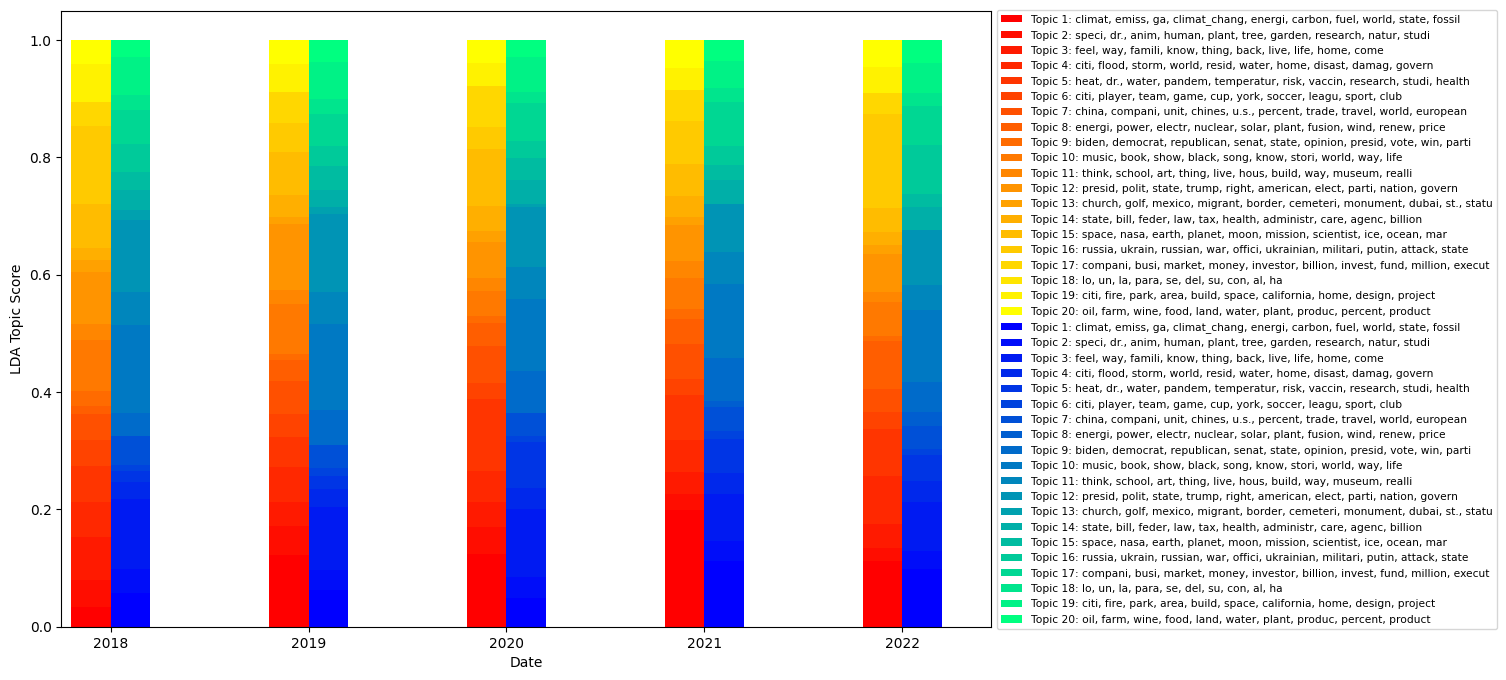

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))

colors_autumn = [cmap_autumn(decimal) for decimal in np.linspace(0.000001, 0.999999, data_bbc_processed_group_day_topics_normal.shape[1])]
colors_winter = [cmap_winter(decimal) for decimal in np.linspace(0.000001, 0.999999, data_nytimes_processed_group_day_topics_normal.shape[1])]

data_bbc_processed_group_day_topics_normal.plot(kind='bar', stacked=True, position=1, ax=ax, width=0.2, color=colors_autumn)
data_nytimes_processed_group_day_topics_normal.plot(kind='bar', stacked=True, position=0, ax=ax, width=0.2, color=colors_winter)
ax.set_xlabel("Date")
ax.set_ylabel("LDA Topic Score")
ax.set_xticklabels([i.strftime(time_freq) for i in data_bbc_processed_group_day_topics_normal.index], rotation=0)
ax.legend(labels=[i + ": " + j for i, j in lda_topics + lda_topics], bbox_to_anchor=(1, 1.01), prop={'size': 7.7});

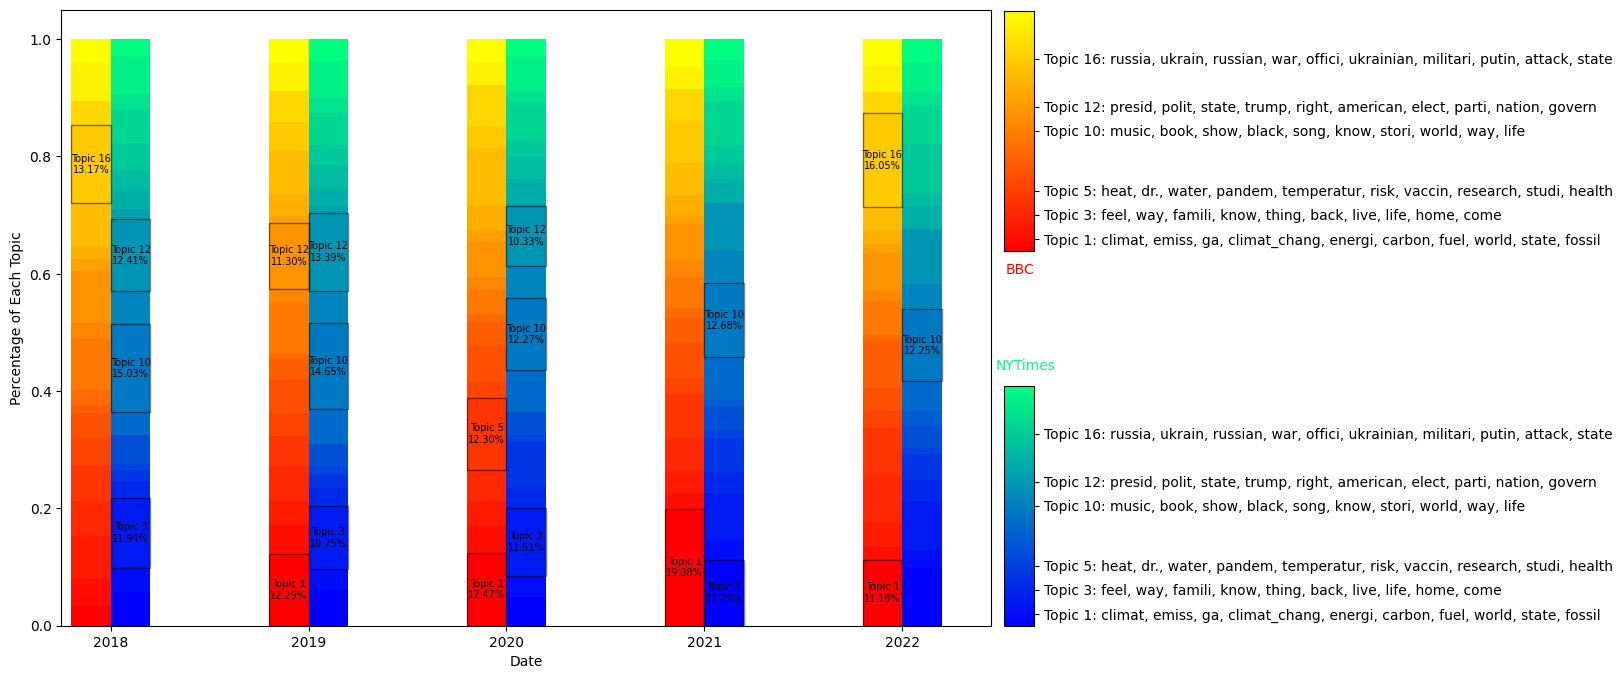

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))

colors_autumn = [cmap_autumn(decimal) for decimal in np.linspace(0.000001, 0.999999, data_bbc_processed_group_day_topics_normal.shape[1])]
colors_winter = [cmap_winter(decimal) for decimal in np.linspace(0.000001, 0.999999, data_nytimes_processed_group_day_topics_normal.shape[1])]

data_bbc_processed_group_day_topics_normal.plot(kind='bar', stacked=True, position=1, ax=ax, width=0.2, color=colors_autumn)
data_nytimes_processed_group_day_topics_normal.plot(kind='bar', stacked=True, position=0, ax=ax, width=0.2, color=colors_winter)

threshold = 0.1

ax_texts = []
for index, (year, row) in enumerate(data_bbc_processed_group_day_topics_normal.iterrows()):
    values_before = 0
    for topic, value in row.iteritems():
        if value >= threshold:
            topics = topic.split("_")
            ax_texts.append(ax.text(index - 0.1, values_before + value / 2, topic + "\n%.2f%%" % (value*100), va = 'center', ha = 'center', size=7))
            ax.add_patch(patches.Rectangle((index - 0.2, values_before), 0.2, value, linewidth=1, edgecolor='black', facecolor='none', alpha=0.5))
        values_before += value

for index, (year, row) in enumerate(data_nytimes_processed_group_day_topics_normal.iterrows()):
    values_before = 0
    for topic, value in row.iteritems():
        if value >= threshold:
            topics = topic.split("_")
            ax_texts.append(ax.text(index + 0.1, values_before + value / 2, topic + "\n".join(topics[1:]) + "\n%.2f%%" % (value*100), va = 'center', ha = 'center', size=7))
            ax.add_patch(patches.Rectangle((index, values_before), 0.2, value, linewidth=1, edgecolor='black', facecolor='none', alpha=0.5))
        values_before += value

ax.set_xlabel("Date")
ax.set_ylabel("Percentage of Each Topic")
ax.set_xticklabels([i.strftime(time_freq) for i in data_bbc_processed_group_day_topics_normal.index], rotation=0)

ax.legend().set_visible(False)
# adjust_text(ax_texts, arrowprops=dict(arrowstyle="->", color='black', lw=0.5, alpha=0.5))

list_ticks = [1, 3, 5, 10, 12, 16]
list_topics = ["%s: %s" % lda_topics[i-1] for i in list_ticks]

plt_sm1 = plt.cm.ScalarMappable(cmap=cmap_autumn, norm=plt.Normalize(vmin=0, vmax=1))
plt_sm1._A = []
axins1 = inset_axes(ax, width='10%', height='2%', bbox_to_anchor=(830, -11290, 300, 12000), loc='upper right')
cbar1 = fig.colorbar(plt_sm1, cax=axins1, orientation='vertical', ticks=[i/20 for i in list_ticks])
cbar1.ax.set_yticklabels(list_topics)

plt_sm2 = plt.cm.ScalarMappable(cmap=cmap_winter, norm=plt.Normalize(vmin=0, vmax=1))
plt_sm2._A = []
axins2 = inset_axes(ax, width='10%', height='2%', bbox_to_anchor=(830, -11665, 300, 12000), loc='upper right')
cbar2 = fig.colorbar(plt_sm2, cax=axins2, orientation='vertical', ticks=[i/20 for i in list_ticks])
cbar2.ax.set_yticklabels(list_topics)

plt.figtext(0.912, 0.55, "BBC", color=colors_autumn[0])
plt.figtext(0.904, 0.43, "NYTimes", color=colors_winter[-1]);
